In [20]:
import numpy as np
seed = 42069
np.random.seed(seed)
import pandas as pd
from matplotlib import pyplot as plt
import arviz
import pystan
from scipy import sparse, stats
from typing import Iterable, Union, Callable
from sklearn.model_selection import train_test_split, ParameterGrid
import altair as alt
from time import time, sleep
from tqdm import tqdm
from multiprocessing import Pool
import pickle

# Own files
import utils 
import StanClasses

# Load and preprocess data

The data we have is essentially a matrix, where the each row correspond to a person, and each column correspond to a movie. However, the matrix is very sparse and thus data is stored in sparse format (i.e. specified with indices and the corresponding values). 

In [2]:
# Define constants
DATA_DIR = 'ml-100k'

In [3]:
df, _, _ = utils.get_ml100k_data(DATA_DIR, subsample_top_users=200, subsample_top_items=200)
df[['user_id', 'item_id']] -= 1

# We are not going to use timestamp, therefore drop it
df.drop('timestamp', axis='columns', inplace=True)

The user ids and item (movie) ids are essentially integer ranges, starting from and 1 to the number of users and items respectively. We don't have the all the unique ids when subsampling users and movies. It becomes problematic ... TODO: Write this

In [4]:
def column_relabler(df: pd.DataFrame, column: str):
    uniques = pd.value_counts(df[column], sort=False).index.values
    n_uniques = len(uniques)

    num2id = {num_:id_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    id2num = {id_:num_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    
    df[column] = df[column].map(id2num)
    return id2num, num2id

df_num = df.copy()
user2num, num2user = column_relabler(df_num, 'user_id')
item2num, num2item = column_relabler(df_num, 'item_id')

# p, q represents shape of the matrix as if it was dense
p, q = len(user2num), len(item2num)

In [5]:
df_train, df_val = train_test_split(df_num, test_size=0.1, random_state=seed)

In [6]:
print(f'''Dataframe dimensions:
    df_train: {df_train.shape}
    df_val: {df_val.shape}
    ''')

Dataframe dimensions:
    df_train: (20699, 3)
    df_val: (2300, 3)
    


# Matrix Factorization 
Want to factorize the dense matrix $X_{n\times m} \approx U_{n\times k}V_{k\times m}$, where the subscripts denotes matrix shapes. The $k$ dimension denotes the user specified embedding dimension. We use different probabilistic models for the components. 


## Model 1: Normal
Not as simple as the simple model above, this is the analogous to the "regular" way when doing regression.

$$ U_{ij} \sim N(\mu_u, \sigma_u) $$
$$ V_{ij} \sim N(\mu_v, \sigma_v) $$
$$ X_{ij}\sim N((UV_{ij}), \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

User defined variables:
$\mu_u, \sigma_u, \mu_v, \sigma_v, a_\beta, b_\beta$

## Model 2: Non-negative Matrix Factorization

$$ U_{ij}\sim Gamma(a_u, b_u) $$
$$ V_{ij}\sim Gamma(a_v, b_v) $$
$$ X_{ij}\sim Normal(UV_{ij}, \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

User defined variables:
$a_u, b_u, a_v, b_v, a_\beta, b_\beta$

## Model 3: ARD

$$ U_{ij} \sim N(\mu_u, \alpha_j) $$
$$ V_{ij} \sim N(\mu_v, \alpha_j) $$
$$ X_{ij}\sim N((UV)_{ij}, \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

$$ \alpha_{j} \sim Gamma(a_\alpha, b_\alpha) $$

User defined variables:
$\mu_u, \mu_v, a_\alpha, b_\alpha, a_\beta, b_\beta$

In [7]:
models = [
    StanClasses.NormalFactorizer,
    StanClasses.NonNegativeFactorizer,
    StanClasses.ARD_Factorizer
]

init_kwargs = {'n_components':[3,5,10,15,20]}
static_kwargs = {'chains':1, 'iter':1000, 'control':{'max_treedepth':15}}

t0 = time()
# hist = utils.fit_and_evaluate_models(
#     models=models,
#     X_train=df_train,
#     X_val=df_val,
#     candidate_kwargs=init_kwargs,
#     static_kwargs=static_kwargs
# )
evaltime = time()-t0

In [8]:
df_hist = pd.read_pickle('histpickle_withmodels2.pkl')
df_hist.sort_values('val_mae', inplace=True)

In [9]:
best_model = df_hist['model'].values[0]
best_params = df_hist['params'].values[0].copy()

In [10]:
print(best_model)
print(best_params)

{'n_components': 5}


In [11]:
best_params.update(static_kwargs)
final_model = type(best_model)(**best_params)

In [12]:
df_full, _, _ = utils.get_ml100k_data(DATA_DIR)
df_full[['user_id', 'item_id']] -= 1

# We are not going to use timestamp, therefore drop it
df_full.drop('timestamp', axis='columns', inplace=True)

df_full_train, df_test = train_test_split(df_full, test_size=0.05, random_state=seed)

In [13]:
# final_model.fit(df_full_train)

In [18]:
df_hist.columns

Index(['model', 'params', 'fit_time', 'train_mae', 'val_mae'], dtype='object')

In [ ]:
final_model_object, fit_time, train_mae, test_mae =\
    utils.fit_and_evaluate((type(best_model), best_params, df_full_train, df_test))

hist2 = {
    'model':final_model_object,
    'params':best_params,
    'fit_time':fit_time,
    'train_mae':train_mae,
    'test_mae':test_mae
}

In [22]:
with open('final_dict.pkl', 'wb') as f:
    pickle.dump(hist2, f)

NameError: name 'hist2' is not defined

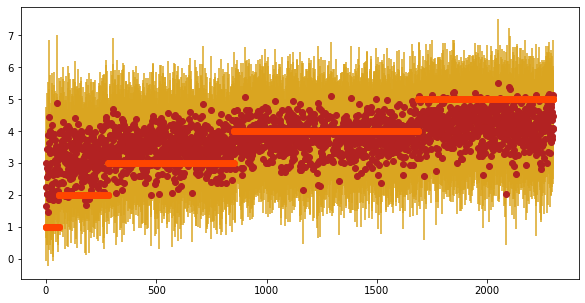

In [14]:
def ci_df(self, df):
    fig, ax = plt.subplots(figsize=(10,5))
    self.ci(row_inds=df.user_id, col_inds=df.item_id, plot=True, zorder=0, ax=ax, 
       c='firebrick', ecolor='goldenrod')
    ax.scatter(range(len(df)), df.rating, c='orangered', zorder=1)
    plt.show()

ci_df(df_hist['model'][0], df_val.sort_values('rating'))

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Test Place

1 0.5


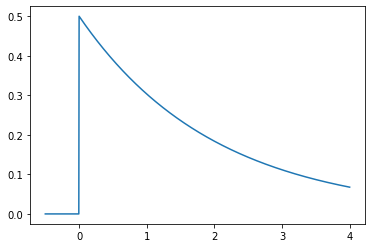

2 8


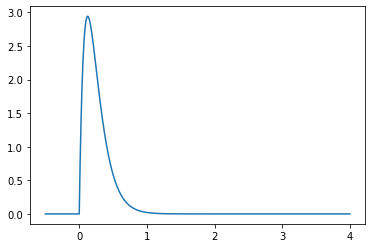

1 0.08


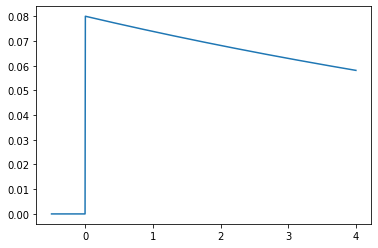

In [15]:
xrange = np.linspace(-0.5,4,1000)

a = 1
b = 0.5*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
plt.show()

a = 2
b = 4*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
plt.show()

a = 1
b = 0.08*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
# plt.axvline(((a-1)/b/(a-1)))
plt.show()

In [16]:
raise ValueError

ValueError: 

In [ ]:
sm_test_code = utils.get_stan_code('sanity.stan')
sm_test = utils.StanModel_cache(sm_test_code, 'test')

In [ ]:
fit_test = sm_test.sampling(algorithm="Fixed_param", chains=4, n_jobs=-1, iter=10)

In [ ]:
A = np.array([[0.674531,0.560879],[-1.82799,0.0132566]])

In [ ]:
A@A

In [ ]:
X_ = 